In [1]:
import os
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
from transformers import AutoTokenizer
from sklearn.metrics import accuracy_score, f1_score, balanced_accuracy_score
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
from sklearn.metrics import confusion_matrix
from collections import OrderedDict

import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.metrics import balanced_accuracy_score, accuracy_score
from tqdm import tqdm

from models.t0 import T0RegressionModel
from datahandles import TabLLMDataObject, FewshotTabLLMDataset, CombinedTabLLMTextDataset
from tabllm.dataset_utils import balance_dataset, load_and_preprocess_dataset
from utils import Config, ConfigObject

os.environ["HF_HOME"] = "/export/pasan/.cache/huggingface"
os.environ["CUDA_VISIBLE_DEVICES"] = "3"

/afs/glue.umd.edu/home/glue/p/a/pasand/home/miniconda3/envs/transhyper2/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
def plot_confusion_matrix(y_true, y_pred, class_names=None, normalize=False, cmap='Blues'):
    """
    Displays a confusion matrix.

    Parameters:
    - y_true: list or array of true labels
    - y_pred: list or array of predicted labels
    - class_names: list of class names (optional)
    - normalize: whether to normalize the matrix (default: False)
    - cmap: color map for the heatmap
    """
    cm = confusion_matrix(y_true, y_pred)
    
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    plt.figure(figsize=(6, 5))
    sns.heatmap(cm, annot=True, fmt=".2f" if normalize else "d", cmap=cmap,
                xticklabels=class_names if class_names else 'auto',
                yticklabels=class_names if class_names else 'auto')
    
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.title('Confusion Matrix' + (' (Normalized)' if normalize else ''))
    plt.tight_layout()
    plt.show()

In [3]:
checkpoint_path = f"save/t0pp-twotrain-bank-income/epoch-6.pth"

checkpoint = torch.load(checkpoint_path, weights_only=False)
cfg = Config(cfg_dict=checkpoint["cfg"])
model = T0RegressionModel(cfg=cfg)
model.load_state_dict(checkpoint['model'])
tokenizer = AutoTokenizer.from_pretrained(cfg.tokenizer.model())

Hyponet mlp initialized with parameter shapes {'wb0': (104, 10), 'wb1': (11, 10), 'wb2': (11, 10), 'wb3': (11, 2)}
Initializing hypernet t0, name: t0, model: bigscience/T0pp
t0 hypernet hidden size: 4096
total hyponet params: 1282


You are using the default legacy behaviour of the <class 'transformers.models.t5.tokenization_t5.T5Tokenizer'>. This is expected, and simply means that the `legacy` (previous) behavior will be used so nothing changes for you. If you want to use the new behaviour, set `legacy=False`. This should only be set if you understand what it means, and thoroughly read the reason why this was added as explained in https://github.com/huggingface/transformers/pull/24565


In [25]:
def load_dataset(ds_name, test_ratio=0.3, val_ratio=0.2):
    cfg_dict = checkpoint["cfg"]
    cfg_dict["datasets"]["list_combine_test"] = [ds_name]
    cfg_dict["datasets"]["balanced"] = {"train": True, "val": False, "test": False}
    cfg_dict["datasets"]["tabllm"]["txt_data_path"] = "tabllm/data/datasets_serialized"
    cfg_dict["datasets"]["test_ratio"] = test_ratio
    cfg_dict["datasets"]["validation_ratio"] = val_ratio
    cfg_dict["debug"] = False
    cfg = Config(cfg_dict=cfg_dict)

    tabllm_do = TabLLMDataObject(cfg=cfg, set_hyponet_in_dim=False)
    test_ds = CombinedTabLLMTextDataset(cfg=cfg, split="test", datapoints=[tabllm_do.split_datapoints[ds_name]], max_n_features=cfg.hyponet.in_dim())

    y = np.array([test_ds[i]["y"] for i in range(len(test_ds))])
    X = np.array([test_ds[i]["x"] for i in range(len(test_ds))])
    print(f"dataset: {ds_name}, X.shape: {X.shape}, y.shape: {y.shape}")
    return X, y, test_ds

In [26]:
def dict_to_mlp(weight_dict: dict[str, torch.Tensor], in_dim:int) -> nn.Sequential:
    """
    Convert a dictionary of 'wbX' -> tensor(out_features, in_features+1)
    into a PyTorch MLP with the given weights and biases.
    
    Args:
        weight_dict: dict with keys like 'wb0', 'wb1', ... and tensors 
                     where the last column is the bias.
    
    Returns:
        model: nn.Sequential containing the layers with weights loaded.
    """
    layers = []
    
    # Sort layers by number (wb0, wb1, ...)
    sorted_keys = sorted(weight_dict.keys(), key=lambda k: int(k[2:]))
    
    for i, key in enumerate(sorted_keys):
        in_dim = in_dim + 1 # inputs and bias
        wb = weight_dict[key][0]
        out_dim = len(wb) // in_dim
        wb = torch.reshape(wb, (in_dim, out_dim))

        in_features = in_dim - 1  # last col = bias
        out_features = out_dim
        bias = wb[-1, :]
        weight = wb[:-1, :]
        
        # Create linear layer
        layer = nn.Linear(in_features, out_features)
        
        # Assign weights and bias (ensure no grad issues)
        with torch.no_grad():
            layer.weight.copy_(torch.transpose(weight, 0 ,1))
            layer.bias.copy_(bias)
        
        layers.append(layer)
        
        # Optionally add non-linearity (ReLU here, skip after last)
        if i < len(sorted_keys) - 1:
            layers.append(nn.ReLU())

        in_dim = out_dim
    
    return nn.Sequential(*layers)

def get_layer_outputs(model, layers_to_hook):
    """
    Registers forward hooks on specified layers and returns a function to get their outputs.

    Args:
        model (nn.Module): The model to hook.
        layers_to_hook (list[str]): List of layer names (use model.named_modules()) to hook.

    Returns:
        - hook_handles: list of hook handles (for later removal).
        - get_outputs: function that takes an input and returns activations from hooked layers.
    """
    activations = OrderedDict()

    def hook_fn(name):
        def fn(module, input, output):
            # Flatten output for CKA computation: [batch_size, features]
            activations[name] = output.view(output.size(0), -1).detach()
        return fn

    hook_handles = []
    for name, module in model.named_modules():
        if name in layers_to_hook:
            handle = module.register_forward_hook(hook_fn(name))
            hook_handles.append(handle)

    def get_outputs(x):
        activations.clear()  # Clear before forward pass
        _ = model(x)
        return [activations[name] for name in layers_to_hook]

    return hook_handles, get_outputs

def center_kernel(K: np.ndarray) -> np.ndarray:
    """
    Center a kernel matrix using the double centering formula:
    K_c = K - 1K - K1 + 1K1
    """
    n = K.shape[0]
    one_n = np.ones((n, n)) / n
    K_centered = K - one_n @ K - K @ one_n + one_n @ K @ one_n
    return K_centered

def cka_matrix(X: np.ndarray, Y: np.ndarray) -> float:
    """
    Compute the Centered Kernel Alignment (CKA) between two sets of representations.
    
    Args:
        X: (n_samples, d1) activations/logits from model 1
        Y: (n_samples, d2) activations/logits from model 2
    
    Returns:
        Scalar CKA similarity between X and Y
    """
    Kx = X @ X.T
    Ky = Y @ Y.T
    
    Kx_centered = center_kernel(Kx)
    Ky_centered = center_kernel(Ky)
    
    numerator = np.sum(Kx_centered * Ky_centered)
    denominator = np.sqrt(np.sum(Kx_centered ** 2) * np.sum(Ky_centered ** 2))
    
    return numerator / denominator

def compute_cka_matrix_list(activations1: list[np.ndarray], activations2: list[np.ndarray]) -> np.ndarray:
    """
    Compute pairwise CKA between all activation matrices in a list.
    """
    n = len(activations1)
    print(f"number of activations: {n}")
    cka_mat = np.zeros((n, n))
    
    for i in range(n):
        for j in range(n):
            print(f"computing ({i},{j})-th element. {activations1[i].shape}, {activations2[i].shape}")
            cka_mat[i, j] = cka_matrix(activations1[i], activations2[j])
    
    return cka_mat

def plot_cka_matrix(cka_mat: np.ndarray, layer_names: list[str]=None, vmin:float=0.0, vmax: float=1.0) -> None:
    """
    Plot the CKA matrix using matplotlib.
    """
    fig, ax = plt.subplots(figsize=(6, 5))
    im = ax.imshow(cka_mat, cmap="viridis", vmin=vmin, vmax=vmax)
    fig.colorbar(im, ax=ax)
    
    if layer_names is not None:
        ax.set_xticks(range(len(layer_names)))
        ax.set_yticks(range(len(layer_names)))
        ax.set_xticklabels(layer_names, rotation=90)
        ax.set_yticklabels(layer_names)
    else:
        ax.set_xticks(range(cka_mat.shape[0]))
        ax.set_yticks(range(cka_mat.shape[0]))
    
    ax.set_title("Centered Kernel Alignment (CKA)")
    plt.tight_layout()
    plt.show()

def get_hyponet_and_data(n_shots, ds_name):
    X, y, test_ds = load_dataset(ds_name)
    if n_shots > 0:
        prompt = "".join([test_ds[i, True] for i in np.random.randint(low=0, high=len(test_ds), size=n_shots)])
    else:
        prompt = "Quick brown fox jumped over the lazy dog!"
        
    tokens = tokenizer(prompt, 
                    truncation=cfg.tokenizer.truncation(), 
                    padding=cfg.tokenizer.padding(), 
                    max_length=cfg.tokenizer.max_length(), 
                    return_tensors='pt')
    return model(tokens), X, y

def load_cka_matrix(file):
    with open(file, 'rb') as f:
        print(f"loaded CKA matrix from {file}")
        return pickle.load(f)

def save_cka_matrix(file, matrix):
    with open(file, 'wb') as f:
        pickle.dump(matrix, f)
        print(f"saved CKA matrix to {file}")


In [6]:
n_shots = 5
hyponet1, X1, y1 = get_hyponet_and_data(n_shots=n_shots, ds_name='calhousing')
hyponet2, X2, y2 = get_hyponet_and_data(n_shots=n_shots, ds_name='income')
hyponet1.eval()
hyponet2.eval()

dataset: calhousing, X.shape: (16513, 103), y.shape: (16513,)
dataset: income, X.shape: (39074, 103), y.shape: (39074,)


HypoMlp(
  (relu): ReLU()
)

In [7]:
mlp1 = dict_to_mlp(hyponet1.params, in_dim=X1.shape[1])
mlp2 = dict_to_mlp(hyponet2.params, in_dim=X2.shape[1])

layers = []
for i, m in mlp1.named_modules():
    layers.append(i)

print(f"layers: {layers}")
handles1, outputs1 = get_layer_outputs(mlp1, layers[1:])
handles2, outputs2 = get_layer_outputs(mlp2, layers[1:])

layers: ['', '0', '1', '2', '3', '4', '5', '6']


In [11]:
acts1 = outputs1(torch.Tensor(X1))
acts2 = outputs2(torch.Tensor(X1))

matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1], 
                                     activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])
save_cka_matrix("./cka_matrix_same_data_diff_prompt.pkl", matrix)

/tmp/ipykernel_3005732/3006912839.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1],
/tmp/ipykernel_3005732/3006912839.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])


number of activations: 7
computing (0,0)-th element. (16513, 10), (16513, 10)
computing (0,1)-th element. (16513, 10), (16513, 10)
computing (0,2)-th element. (16513, 10), (16513, 10)
computing (0,3)-th element. (16513, 10), (16513, 10)
computing (0,4)-th element. (16513, 10), (16513, 10)
computing (0,5)-th element. (16513, 10), (16513, 10)
computing (0,6)-th element. (16513, 10), (16513, 10)
computing (1,0)-th element. (16513, 10), (16513, 10)
computing (1,1)-th element. (16513, 10), (16513, 10)
computing (1,2)-th element. (16513, 10), (16513, 10)
computing (1,3)-th element. (16513, 10), (16513, 10)
computing (1,4)-th element. (16513, 10), (16513, 10)
computing (1,5)-th element. (16513, 10), (16513, 10)
computing (1,6)-th element. (16513, 10), (16513, 10)
computing (2,0)-th element. (16513, 10), (16513, 10)
computing (2,1)-th element. (16513, 10), (16513, 10)
computing (2,2)-th element. (16513, 10), (16513, 10)
computing (2,3)-th element. (16513, 10), (16513, 10)
computing (2,4)-th el

In [ ]:
acts1 = outputs1(torch.Tensor(X1))
acts2 = outputs2(torch.Tensor(X2[:16513]))

matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1], 
                                     activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])
save_cka_matrix("./blah.pkl", matrix)

/tmp/ipykernel_3005732/3919453240.py:4: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  matrix = compute_cka_matrix_list(activations1=[np.array(a.detach(), dtype=np.float32) for a in acts1],
/tmp/ipykernel_3005732/3919453240.py:5: DeprecationWarning: __array__ implementation doesn't accept a copy keyword, so passing copy=False failed. __array__ must implement 'dtype' and 'copy' keyword arguments. To learn more, see the migration guide https://numpy.org/devdocs/numpy_2_0_migration_guide.html#adapting-to-changes-in-the-copy-keyword
  activations2=[np.array(a.detach(), dtype=np.float32) for a in acts2])


number of activations: 7
computing (0,0)-th element. (16513, 10), (16513, 10)
computing (0,1)-th element. (16513, 10), (16513, 10)
computing (0,2)-th element. (16513, 10), (16513, 10)
computing (0,3)-th element. (16513, 10), (16513, 10)
computing (0,4)-th element. (16513, 10), (16513, 10)
computing (0,5)-th element. (16513, 10), (16513, 10)
computing (0,6)-th element. (16513, 10), (16513, 10)
computing (1,0)-th element. (16513, 10), (16513, 10)
computing (1,1)-th element. (16513, 10), (16513, 10)
computing (1,2)-th element. (16513, 10), (16513, 10)
computing (1,3)-th element. (16513, 10), (16513, 10)
computing (1,4)-th element. (16513, 10), (16513, 10)
computing (1,5)-th element. (16513, 10), (16513, 10)
computing (1,6)-th element. (16513, 10), (16513, 10)
computing (2,0)-th element. (16513, 10), (16513, 10)
computing (2,1)-th element. (16513, 10), (16513, 10)
computing (2,2)-th element. (16513, 10), (16513, 10)
computing (2,3)-th element. (16513, 10), (16513, 10)
computing (2,4)-th el

loaded CKA matrix from ./cka_matrix_diff_data_diff_prompt.pkl
min: 7.6013280597439675e-06, max: 6.592910169797601e-05


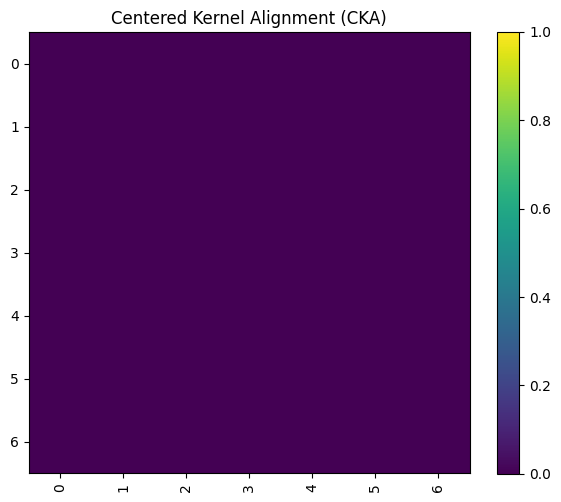

In [40]:
loaded_matrix = load_cka_matrix("./cka_matrix_diff_data_diff_prompt.pkl")
print(f"min: {np.min(loaded_matrix)}, max: {np.max(loaded_matrix)}")
plot_cka_matrix(cka_mat=loaded_matrix, vmin=0.0, vmax=1, layer_names=layers[1:])

# Train raw MLP

In [27]:
def load_train_dataset():
    cfg_dict = checkpoint["cfg"]
    cfg_dict["datasets"]["balanced"] = {"train": True, "val": False, "test": False}
    cfg_dict["datasets"]["tabllm"]["txt_data_path"] = "tabllm/data/datasets_serialized"
    cfg_dict["datasets"]["test_ratio"] = 0.3
    cfg_dict["datasets"]["validation_ratio"] = 0.2
    cfg_dict["debug"] = False
    cfg = Config(cfg_dict=cfg_dict)

    tabllm_do = TabLLMDataObject(cfg=cfg, set_hyponet_in_dim=False)
    train_ds = CombinedTabLLMTextDataset(cfg=cfg, 
                                         split="train", 
                                         datapoints=[k for k in tabllm_do.split_datapoints.values()], 
                                         max_n_features=cfg.hyponet.in_dim())

    y = np.array([train_ds[i]["y"] for i in range(len(train_ds))])
    X = np.array([train_ds[i]["x"] for i in range(len(train_ds))])
    print(f"X.shape: {X.shape}, y.shape: {y.shape}")
    return X, y

In [28]:
X, y = load_train_dataset()

X.shape: (27516, 103), y.shape: (27516,)


In [29]:
class MLP(nn.Module):
    def __init__(self, in_dim, hidden_dim, out_dim, *args, **kwargs) -> None:
        super().__init__(*args, **kwargs)
        self.model = nn.Sequential(
            nn.Linear(in_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, hidden_dim),
            nn.ReLU(),
            nn.Linear(hidden_dim, out_dim),
        )

    def forward(self, X):
        return self.model(X)

In [30]:
def train_mlp_with_loaders(model, 
                           X_train, y_train, 
                           X_test, y_test, 
                           batch_size=32, 
                           epochs=20, 
                           lr=1e-3, 
                           device='cuda'):
    
    # Create DataLoaders
    train_dataset = TensorDataset(X_train, y_train)
    test_dataset = TensorDataset(X_test, y_test)
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

    model = model.to(device)
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=lr)

    # Metric storage
    train_acc_list, val_acc_list = [], []
    train_bal_acc_list, val_bal_acc_list = [], []

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        loop = tqdm(train_loader, desc=f"Epoch [{epoch+1}/{epochs}]", leave=False)
        for X_batch, y_batch in loop:
            X_batch, y_batch = X_batch.to(device), y_batch.to(device)

            optimizer.zero_grad()
            outputs = model(X_batch)
            loss = criterion(outputs, y_batch)
            loss.backward()
            optimizer.step()

            loop.set_postfix(loss=loss.item())

        # ---- Compute train metrics ----
        model.eval()
        train_true, train_pred = [], []
        with torch.no_grad():
            for Xb, yb in train_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb).argmax(dim=1)
                train_true.extend(yb.cpu().numpy())
                train_pred.extend(preds.cpu().numpy())
        train_acc = accuracy_score(train_true, train_pred)
        train_bal_acc = balanced_accuracy_score(train_true, train_pred)

        # ---- Compute validation metrics ----
        val_true, val_pred = [], []
        with torch.no_grad():
            for Xb, yb in test_loader:
                Xb, yb = Xb.to(device), yb.to(device)
                preds = model(Xb).argmax(dim=1)
                val_true.extend(yb.cpu().numpy())
                val_pred.extend(preds.cpu().numpy())
        val_acc = accuracy_score(val_true, val_pred)
        val_bal_acc = balanced_accuracy_score(val_true, val_pred)

        # Store
        train_acc_list.append(train_acc)
        train_bal_acc_list.append(train_bal_acc)
        val_acc_list.append(val_acc)
        val_bal_acc_list.append(val_bal_acc)

        tqdm.write(
            f"Epoch {epoch+1}/{epochs} "
            f"- Train Acc: {train_acc:.4f}, Train BalAcc: {train_bal_acc:.4f} "
            f"- Val Acc: {val_acc:.4f}, Val BalAcc: {val_bal_acc:.4f}"
        )

    # ---- Plot ----
    plt.figure(figsize=(10,5))
    plt.plot(range(1, epochs+1), train_acc_list, label='Train Accuracy', marker='x')
    plt.plot(range(1, epochs+1), val_acc_list, label='Val Accuracy', marker='x')
    plt.plot(range(1, epochs+1), train_bal_acc_list, label='Train Balanced Acc', marker='s')
    plt.plot(range(1, epochs+1), val_bal_acc_list, label='Val Balanced Acc', marker='s')
    plt.xlabel("Epoch")
    plt.ylabel("Score")
    plt.title("Train vs Validation Metrics per Epoch")
    plt.legend()
    plt.grid(True)
    plt.show()

    return {
        "train_acc": train_acc_list,
        "train_bal_acc": train_bal_acc_list,
        "val_acc": val_acc_list,
        "val_bal_acc": val_bal_acc_list
    }

In [31]:
mlp = MLP(in_dim=103, hidden_dim=10, out_dim=2)
X_test, y_test, _ = load_dataset(ds_name="calhousing")

X = torch.tensor(X)
y = torch.tensor(y, dtype=torch.long)

X_test = torch.tensor(X_test)
y_test = torch.tensor(y_test, dtype=torch.long)

dataset: calhousing, X.shape: (6192, 103), y.shape: (6192,)


Epoch 1/20 - Train Acc: 0.8028, Train BalAcc: 0.8028 - Val Acc: 0.8186, Val BalAcc: 0.8185


Epoch 2/20 - Train Acc: 0.8160, Train BalAcc: 0.8160 - Val Acc: 0.8319, Val BalAcc: 0.8323


Epoch 3/20 - Train Acc: 0.8260, Train BalAcc: 0.8260 - Val Acc: 0.8319, Val BalAcc: 0.8324


Epoch 4/20 - Train Acc: 0.8274, Train BalAcc: 0.8274 - Val Acc: 0.8348, Val BalAcc: 0.8351


Epoch 5/20 - Train Acc: 0.8255, Train BalAcc: 0.8255 - Val Acc: 0.8322, Val BalAcc: 0.8324


Epoch 6/20 - Train Acc: 0.8306, Train BalAcc: 0.8306 - Val Acc: 0.8343, Val BalAcc: 0.8344


Epoch 7/20 - Train Acc: 0.8359, Train BalAcc: 0.8359 - Val Acc: 0.8379, Val BalAcc: 0.8379


Epoch 8/20 - Train Acc: 0.8351, Train BalAcc: 0.8351 - Val Acc: 0.8375, Val BalAcc: 0.8374


Epoch 9/20 - Train Acc: 0.8372, Train BalAcc: 0.8372 - Val Acc: 0.8385, Val BalAcc: 0.8390


Epoch 10/20 - Train Acc: 0.8352, Train BalAcc: 0.8352 - Val Acc: 0.8316, Val BalAcc: 0.8321


Epoch 11/20 - Train Acc: 0.8371, Train BalAcc: 0.8371 - Val Acc: 0.8356, Val BalAcc: 0.8360


Epoch 12/20 - Train Acc: 0.8371, Train BalAcc: 0.8371 - Val Acc: 0.8367, Val BalAcc: 0.8367


Epoch 13/20 - Train Acc: 0.8385, Train BalAcc: 0.8385 - Val Acc: 0.8367, Val BalAcc: 0.8369


Epoch 14/20 - Train Acc: 0.8367, Train BalAcc: 0.8367 - Val Acc: 0.8324, Val BalAcc: 0.8321


Epoch 15/20 - Train Acc: 0.8353, Train BalAcc: 0.8353 - Val Acc: 0.8330, Val BalAcc: 0.8335


Epoch 16/20 - Train Acc: 0.8373, Train BalAcc: 0.8373 - Val Acc: 0.8395, Val BalAcc: 0.8389


Epoch 17/20 - Train Acc: 0.8407, Train BalAcc: 0.8407 - Val Acc: 0.8387, Val BalAcc: 0.8386


Epoch 18/20 - Train Acc: 0.8379, Train BalAcc: 0.8379 - Val Acc: 0.8316, Val BalAcc: 0.8319


Epoch 19/20 - Train Acc: 0.8417, Train BalAcc: 0.8417 - Val Acc: 0.8385, Val BalAcc: 0.8383


Epoch 20/20 - Train Acc: 0.8418, Train BalAcc: 0.8418 - Val Acc: 0.8424, Val BalAcc: 0.8426


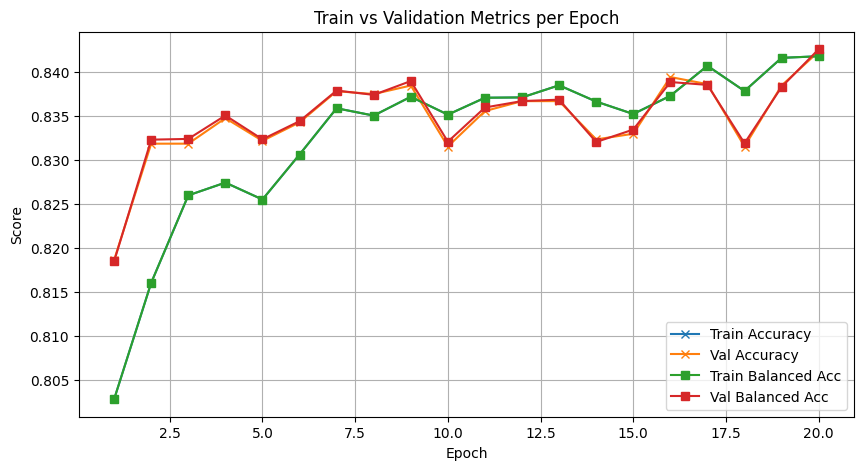

In [32]:
metrics = train_mlp_with_loaders(model=mlp, 
                                 X_train=X, 
                                 y_train=y, 
                                 X_test=X_test, 
                                 y_test=y_test)

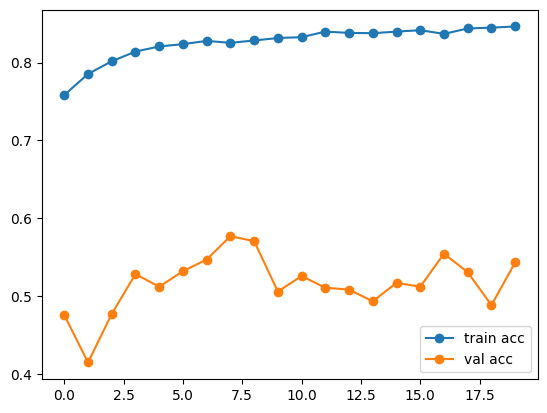

In [52]:
plt.plot(metrics["train_acc"], label="train acc", marker="o")
plt.plot(metrics["val_acc"], label="val acc", marker="o")
plt.legend()